In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from FDTDStaggered3D_with_relaxation.H5pySimple import ReadFromH5py,SaveToH5py
from FDTDStaggered3D_with_relaxation.PropagationModel import PropagationModel
from scipy import ndimage
from ai.cs import sp2cart, mx_rot_y
from skimage.draw import circle_perimeter,disk
from skimage.transform import rotate
PModel=PropagationModel()


### Preamble
Please consult the previous examples for the basics how to run a simulation, understanding of how to prepare correctly the directivity of a source and how to prepare a focusing source

This is pretty much the same simulation as in the notebook `4 - Water- lossless solid media` but this time we add attenuation values to the solid material.

# 1- Water - attenuating solid 


Domain size 297 161 270


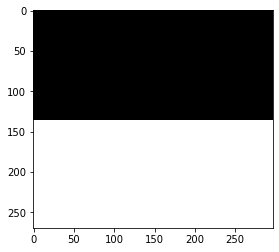

In [9]:
Frequency = 350e3  # Hz
WaterSOS = 1500 # m/s - water
WaterDensity=1000 # kg/m3

#Acryic
SolidLSOS = 2848 # m/s - 
SolidsSOS = 1026 # m/s - 
SolidDensity=1190 # kg/m3
SolidLAlpha = 34 # Np/m 
SolidSAlpha= 163 # Np/m 

ShortestWavelength =SolidsSOS / Frequency
SpatialStep =ShortestWavelength / 8.0 # A minimal step of 6 is recommnded

DimDomain =  np.array([0.1,0.05,0.09])  # in m, x,y,z  # in m, x,y,z

TxRadius = 0.04 # m, 
TxDiameter=0.04
PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, IGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/SolidsSOS #time to cross one corner to another
TemporalStep=5e-8 # if this step is too coarse a warning will be generated (but simulation will continue,) 

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((2,5)) # two materials in this example
MaterialList[0,0]=WaterDensity # water density
MaterialList[0,1]=WaterSOS # water SoS

MaterialList[1,0]=SolidDensity # plastic density
MaterialList[1,1]=SolidLSOS # plastic long. SoS
MaterialList[1,2]=SolidDensity # plastic shear SoS
MaterialList[1,3]=SolidLAlpha # plastic long. attenuation
MaterialList[1,4]=SolidSAlpha # plastic shear attenuation

#we define two - half spaces

MaterialMap[:,:,int(N3/2)+1:]=1

plt.figure()
plt.imshow(MaterialMap[:,int(N2/2),:].T,cmap=plt.cm.gray);

#all other parameters are set to 0 


We apply the concepts on directivity to model a spherical cap for a focusing source. Below there is a function that uses scikit-image to prepare the mask of a spherical cap and how we can prepare correctly the directivity of each entry in the source mask.

In [10]:
def MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,Angle):
    #simple defintion of a focusing source centred in the domain, 
    #please note this is not a bullet-proof solution as it may not work for all cases
    XDim=np.arange(N1)*SpatialStep
    YDim=np.arange(N2)*SpatialStep
    ZDim=np.arange(N3)*SpatialStep
    XDim-=XDim[int(N1/2)]
    YDim-=YDim[int(N2/2)]
    ZDim-=ZDim[int(N3/2)]
    XX,YY,ZZ=np.meshgrid(YDim,XDim,ZDim)#note we have to invert this because how meshgrid works
    Depth=np.sqrt(TxRadius**2-(TxDiameter/2.0)**2)
    cX=int(N1/2)
    cZ=int(N3/2)
    
    MaskSource=np.zeros((N1,N2,N3),np.bool)
    FillMask=np.zeros((N1,N2,N3))
    
    for n,y in enumerate(YDim):
        if np.abs(y)<TxRadius:
            cDiam=int(np.ceil(TxRadius*np.sin(np.arccos(y/TxRadius))/SpatialStep))
            rr, cc = circle_perimeter(cX,cZ,cDiam,shape=(N1,N3))
            MaskSource[rr,n,cc]=np.True_
            rr,cc=disk((cX,cZ),cDiam+1,shape=(N1,N3))
            FillMask[rr,n,cc]=1
            
    
    FillMask[ZZ<=-Depth]=0.
    #instead of rotating the arc, we rotate the mask that will negate the perimeter to be turned off
    if Angle!=0.:
        for n in range(N2):
            FillMask[:,n,:]=rotate(FillMask[:,n,:],Angle,preserve_range=True)
        
    MaskSource[FillMask!=0]=False
        
    #since the sphere mask is 0-centred, the orientation vectors in each point is straighforward
    OxOyOz=np.vstack((-XX.flatten(),-YY.flatten(),-ZZ.flatten())).T
    #and we just normalize
    OxOyOz/=np.tile( np.linalg.norm(OxOyOz,axis=1).reshape(OxOyOz.shape[0],1),[1,3])
    Ox=OxOyOz[:,1].reshape(XX.shape) 
    Oy=OxOyOz[:,0].reshape(XX.shape)
    Oz=OxOyOz[:,2].reshape(XX.shape)
    Ox[MaskSource==False]=0
    Oy[MaskSource==False]=0
    Oz[MaskSource==False]=0
    return MaskSource.astype(np.uint32),Ox,Oy,Oz

We use a rotated focusing source so we can analyze the multiple stress that are generated once the acoustic beam reaches the solid

<ipython-input-10-50cc9db3e123>:38: RuntimeWarning: invalid value encountered in true_divide
  OxOyOz/=np.tile( np.linalg.norm(OxOyOz,axis=1).reshape(OxOyOz.shape[0],1),[1,3])


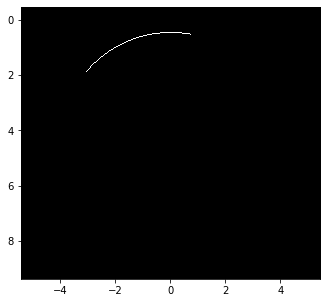

In [11]:
SourceMap,Ox,Oy,Oz=MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,-20)
XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray,extent=[XDim.min(),XDim.max(),ZDim.max(),ZDim.min()]);

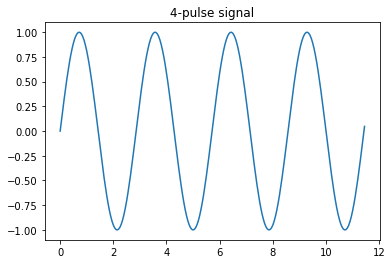

In [12]:
LengthSource=4.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource)
plt.title('4-pulse signal')

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource))) 

In [13]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

### Collect stress data
So far in the previous examples, we have collected only particle displacement, this time we will specify to collect stress data

In [15]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=1,
                                                         USE_SINGLE=True,
                                                         SelMapsRMSPeakList=['ALLV','Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz'],
                                                         DefaultGPUDeviceName='SUPER',
                                                         TypeSource=1)

VLongInput,VShearInput [1500. 2848.] [   0. 1190.]
Q_cw_factor_long,Q_cw_factor_shear [0.96040047 1.        ] [0.9157188 1.       ]
VLongMat,VShearMat [1500.         2735.22055196] [   0.         1089.70537314]
[6.043137039821957e-08, 1.4947919696317205e-07]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 5.982705669423738e-08 [1500.         2735.22055196] [   0.         1089.70537314] [0.         0.15950179] [0.       0.346798] [4.54728409e-07] [1500. 2848.] [   0. 1190.]
Matrix size= 297 x 161 x 270 , spatial resolution = 0.000366429, time steps = 2339, temporal step = 5.98271e-08, total sonication length 0.00013989 
Performing Simulation wtih GPU CUDA
Running with new interface conditions
SizePML=0
SizePMLxp1=0
SizePMLyp1=0
SizePMLzp1=0
SizePMLxp1yp1zp1=0
 Staggered FDTD - compiled at Dec 29 2020 - 17:07:16
N1, N2,N3 , ZoneCount and DT= 297,161,270,5.98271e-08
Number of sensors x timesteps= 67158, 2339
before cudaGetDeviceCount 
after cudaGetDeviceCount 
There

### Ploting data
Because the attenuation in the solid, this time we plot in dB scale.

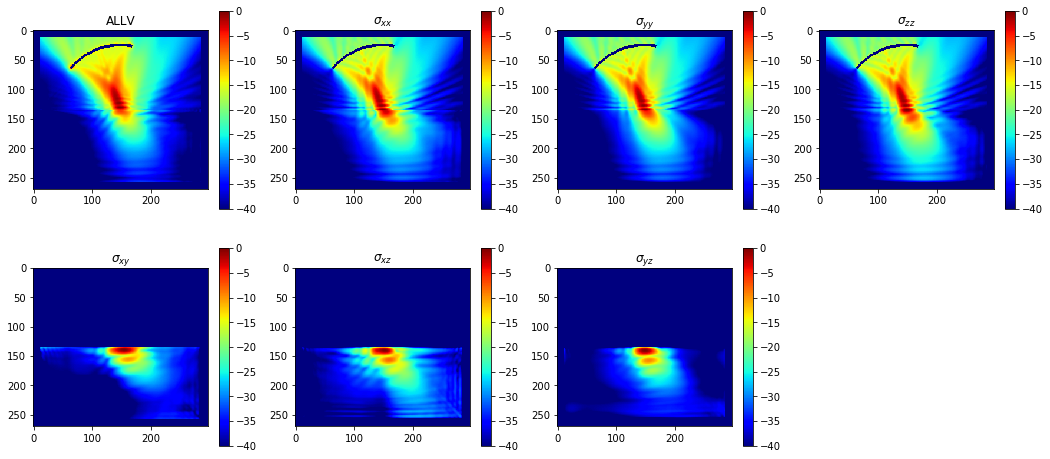

In [19]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/np.max(selP))
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-40,vmax=0)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1


This time, as the attenuation of the shear wave is much higher, the longitudinal component dominates.

# Solid surrounded by water

Now this time we simulate the case a block of plastic (1.4 cm-thick) is surrounded by water

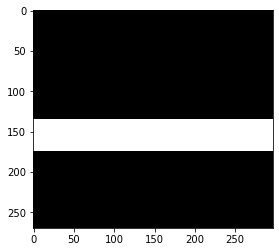

In [20]:
MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((2,5)) # two materials in this example
MaterialList[0,0]=WaterDensity # water density
MaterialList[0,1]=WaterSOS # water SoS

MaterialList[1,0]=SolidDensity # plastic density
MaterialList[1,1]=SolidLSOS # plastic long. SoS
MaterialList[1,2]=SolidDensity # plastic shear SoS

#we define two - half spaces

MaterialMap[:,:,int(N3/2):int(N3/2)+40]=1

plt.figure()
plt.imshow(MaterialMap[:,int(N2/2),:].T,cmap=plt.cm.gray);


In [21]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=1,
                                                         USE_SINGLE=True,
                                                         SelMapsRMSPeakList=['ALLV','Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz'],
                                                         DefaultGPUDeviceName='SUPER',
                                                         TypeSource=1)

VLongInput,VShearInput [1500. 2848.] [   0. 1190.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500. 2848.] [   0. 1190.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 6.303432725005773e-08 [1500. 2848.] [   0. 1190.] [0.] [0.] [4.54728409e-07] [1500. 2848.] [   0. 1190.]
Matrix size= 297 x 161 x 270 , spatial resolution = 0.000366429, time steps = 2220, temporal step = 6.30343e-08, total sonication length 0.00013989 
Performing Simulation wtih GPU CUDA
Running with new interface conditions
SizePML=0
SizePMLxp1=0
SizePMLyp1=0
SizePMLzp1=0
SizePMLxp1yp1zp1=0
 Staggered FDTD - compiled at Dec 29 2020 - 17:07:16
N1, N2,N3 , ZoneCount and DT= 297,161,270,6.30343e-08
Number of sensors x timesteps= 67158, 2220
before cudaGetDeviceCount 
after cudaGetDeviceCount 
There is 1 device.
Found device [0:0]:
  Name: GeForce RTX 2080 SUPER
  Compute capability: 7.5
  Total memory: 8589934592 bytes
  Threads per block: 1024
  Max block dimensions: 1024 x 1

### Ploting data

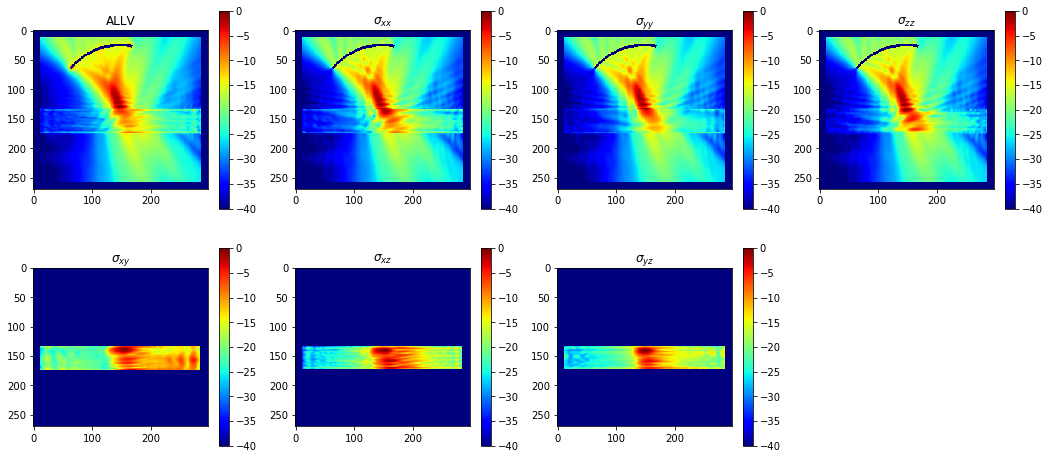

In [24]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/np.max(selP))
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-40,vmax=0)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1

Even with the attenuation being considered, we can appreciate in the all "All_V" map that two patterns appear in the far field water domain, indicating the longitudinal and shear type conversion. The longitudinal transmission being the field more refracted.

# Above critical angle
The previous example used an acoustic beam hitting the block material with an inciden angle of 20 degrees. The critical angle for this material is around 38 degrees. To show only shear-type transmission through the solid, this time we run the simulation with an incident angle of 45 degrees.

<ipython-input-10-50cc9db3e123>:38: RuntimeWarning: invalid value encountered in true_divide
  OxOyOz/=np.tile( np.linalg.norm(OxOyOz,axis=1).reshape(OxOyOz.shape[0],1),[1,3])


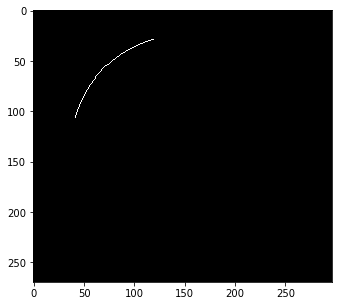

In [25]:
SourceMap,Ox,Oy,Oz=MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,-45)
XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray);

In [26]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=1,
                                                         USE_SINGLE=True,
                                                         SelMapsRMSPeakList=['ALLV','Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz'],
                                                         DefaultGPUDeviceName='SUPER',
                                                         TypeSource=1)

VLongInput,VShearInput [1500. 2848.] [   0. 1190.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500. 2848.] [   0. 1190.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 6.303432725005773e-08 [1500. 2848.] [   0. 1190.] [0.] [0.] [4.54728409e-07] [1500. 2848.] [   0. 1190.]
Matrix size= 297 x 161 x 270 , spatial resolution = 0.000366429, time steps = 2220, temporal step = 6.30343e-08, total sonication length 0.00013989 
Performing Simulation wtih GPU CUDA
Running with new interface conditions
SizePML=0
SizePMLxp1=0
SizePMLyp1=0
SizePMLzp1=0
SizePMLxp1yp1zp1=0
 Staggered FDTD - compiled at Dec 29 2020 - 17:07:16
N1, N2,N3 , ZoneCount and DT= 297,161,270,6.30343e-08
Number of sensors x timesteps= 67158, 2220
before cudaGetDeviceCount 
after cudaGetDeviceCount 
There is 1 device.
Found device [0:0]:
  Name: GeForce RTX 2080 SUPER
  Compute capability: 7.5
  Total memory: 8589934592 bytes
  Threads per block: 1024
  Max block dimensions: 1024 x 1

### Ploting data

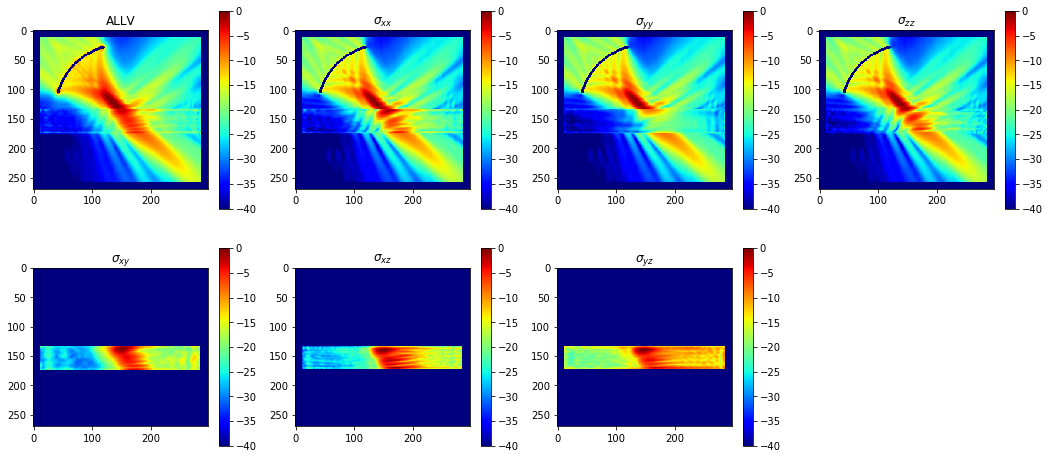

In [29]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/np.max(selP))
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-40,vmax=0)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1

As in the previous notebook, the transmitted field in the far field is much more coherent given that there is not mix between shear-mode and longitudinal-mode conversion. The field inside the solid shows  clearly a refracted field with a  transmission angle that is lower than the incident angle, which is expected as the shear speed of sound is less that the longitidunal speed of sound in water. Once the acoustic waves reaches the second water domain in the far fieldwe obtain back a refracted beam that recovers the same transmission angle as the incident angle in the top domain.